# Neural Network Classification in PyTorch

Classification is one of the most fundamental tasks in supervised machine learning, where the objective is to assign input data to one or more predefined categories. Neural networks, with their ability to learn complex patterns from data, have become powerful tools for solving a wide range of classification problems across domains such as computer vision, natural language processing, and bioinformatics.

In this notebook, we focus on neural networks as **classifiers**  - models trained to distinguish between classes based on the features of the input data. While the underlying principles of training remain consistent, the nature of the classification task can vary significantly depending on the structure of the output space. Specifically, we distinguish between:

- **Binary classification**, where the model must decide between two possible classes (e.g., spam vs. not spam).
- **Multiclass classification**, where the model chooses one class from a set of more than two mutually exclusive categories (e.g., digit recognition from 0 to 9).
- **Multilabel classification**, where multiple labels may be assigned to a single input instance, allowing for overlapping classes (e.g., tagging an image as both "cat" and "outdoors").

Each of these scenarios has implications for how the neural network is structured, how the outputs are interpreted, and which loss functions and evaluation metrics are most appropriate. Throughout this notebook, we will explore these distinctions in detail, and demonstrate how to implement and train neural network classifiers tailored to each classification paradigm using PyTorch.


![Example of encoding an RGB image](https://github.com/MatteoFalcioni/PyTorch_basics/blob/main/imgs/02-different-classification-problems.png?raw=1)

## Typical Architecture of a Neural Network Classifier

| **Hyperparameter**         | **Binary Classification**                                                                 | **Multiclass Classification**                                                  |
|---------------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| **Input layer shape** (`in_features`) | Same as the number of input features (e.g., 5 for age, sex, height, weight, smoking status) | Same as binary classification                                                  |
| **Hidden layers**          | Problem-specific; minimum 1, no strict maximum                                            | Same as binary classification                                                  |
| **Neurons per hidden layer** | Typically between 10 and 512; depends on data and model complexity                        | Same as binary classification                                                  |
| **Output layer shape** (`out_features`) | 1 (to predict a probability of class 1 vs. class 0)                               | 1 per class (e.g., 3 for food, person, or dog)                                 |
| **Hidden layer activation**| Usually ReLU (`torch.nn.ReLU`), but others are possible                                   | Same as binary classification                                                  |
| **Output activation**      | Sigmoid (`torch.sigmoid`)                                                                 | Softmax (`torch.softmax`)                                                      |
| **Loss function**          | Binary Cross-Entropy (`torch.nn.BCELoss`)                                                 | Cross-Entropy (`torch.nn.CrossEntropyLoss`)                                    |
| **Optimizer**              | SGD (stochastic gradient descent), Adam (see `torch.optim` for more options)              | Same as binary classification                                                  |


## 1. Make classification data and get it ready

Let's create our own data. We are going to make a dataset of circles.

In [33]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)  # returns as y an array of 0's and 1's

In [34]:
print(f"first 5 samples of X: {X[:5]}")
print(f"first 5 samples of y: {y[:5]}")

first 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y: [1 1 1 1 0]


Labels `y` are only $0$ or $1$ --> binary classification!

### 1.1 Create a DataFrame

Let's make a pandas dataframe for clarity. `X` is bi-dimensional, so let's do:

In [35]:
# DataFrame of circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


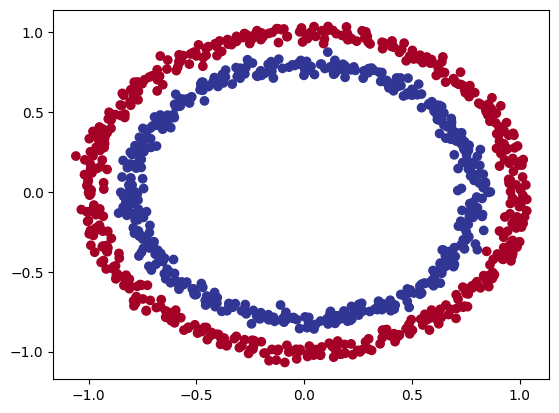

In [36]:
# How about visualizing X1 vs X2

from matplotlib import pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Our toy dataset is composed of points belonging to 1 circle or another. Can we train our network to distinguish between red points and blue points?

Let's check data shapes

In [37]:
X.shape, y.shape

((1000, 2), (1000,))

$2$ is the number of features representing our data; in this case just $2$, but could be waaaay bigger.

In [38]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn Data into Tensors

In [39]:
import torch

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

X = torch.from_numpy(X).type(torch.float) # to have torch.float32, otherwise would be torch.float64
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]


Using device: cuda


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [40]:
X = X.to(device)
y = y.to(device)

### 1.3 Split Data into Training and Test

In [41]:
# Use sklearn to split
from sklearn.model_selection import train_test_split

# just one line in sk learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # ordering of returns is fixed to this one

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Classifier

In [42]:
# import torch

import torch
from torch import nn

# device agnostic (already did above, just for clarity)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# build model class

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)  # we want to create two linear layers so 2 -> 5
    self.layer2 = nn.Linear(in_features=5, out_features=1)  # then 5 -> 1

  # define forward() method
  def forward(self, x):
    return self.layer2(self.layer1(x))


# instantiate a model
model_0 = CircleModelV0().to(device)
model_0

Using device: cuda


CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [43]:
# Let's replicate using nn.Sequential() - standard torch andjust better overall

# import torch

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layers = nn.Sequential(  # equivalent to above
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )

  def forward(self, x):
    return self.linear_layers(x)


# instantiate a model
model_0 = CircleModelV0().to(device)
model_0

Using device: cuda


CircleModelV0(
  (linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [44]:
# make some untrained predictions

with torch.inference_mode():
  untrained_preds = model_0.forward(X_test)

untrained_preds[:10]

tensor([[-0.0477],
        [ 0.1137],
        [-0.4259],
        [ 0.0593],
        [-0.3548],
        [-0.2569],
        [ 0.1411],
        [ 0.0545],
        [-0.4283],
        [ 0.1253]], device='cuda:0')

In [45]:
# of course right now they will be wrong since we didn't train

y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')

Notice that the outputs from our model (`untrained_preds`) are not whole numbers, and they don't directly match the ground truth labels, which are 0s and 1s in this case.

This is expected. First of all, we haven't trained the model yet, so its weights are still random. But *even in a trained model, the outputs are usually not class labels*. Instead, the model returns continuous values that we often refer to as **logits**.

In binary classification, when we apply a sigmoid activation function to the logits, we get values between 0 and 1. These can be interpreted as the model's confidence (or probability) that the input belongs to class 1. For example, a prediction of $0.72$ means the model is $72 \%$ confident the input should be classified as class 1.

In [46]:
# output = logits ---sigmoid---> probabilities
y_probs = torch.sigmoid(untrained_preds)
y_probs[:10]

tensor([[0.4881],
        [0.5284],
        [0.3951],
        [0.5148],
        [0.4122],
        [0.4361],
        [0.5352],
        [0.5136],
        [0.3945],
        [0.5313]], device='cuda:0')



To compare predictions to the ground truth, we usually apply a threshold (often $0.5$) to convert the output into a class label: values above the threshold are interpreted as class 1, and values below as class 0.





In [47]:
torch.round(y_probs)[:10]   # will be wrong (untrained)

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]], device='cuda:0')


In multiclass classification, we use a softmax function instead of a sigmoid. This transforms the logits into a probability distribution across all possible classes.

So, the important point is that neural networks typically output continuous values, and we must interpret or post-process them to obtain final class predictions.

For a deeper dive, see **entropic theory of info LINK!**

So, knowing this, we should choose our loss accordingly. We basically want to aply a sigmoid layer to our outputs and then compute the loss on these probabilities. Fortunately, torch's [`nn.BCEWithLogitsLoss()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss) does both steps for us: it applies a sigmoid function to our layer and then computes the *Cross Entropy Loss*.

> **Note:** There exists also a method called [`.nn.BCELoss()](`https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss), that doesn't automatically apply the sigmoid function. As a result, it is more numerically unstable and `BCEWithLogitsLoss()` should be the preferred choice.   

In [48]:
# setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

# setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                              lr=0.1)

The last thing we could do is set up an evaluation metric, for example an accuracy function. It gives us the same info as the loss, but from a different perspective.

In [49]:
def accuracy_fn(y_pred, y_true):  # we could use sklearn accuracy, but let's use ours this time
  n_correct = torch.eq(y_pred, y_true).sum().item()
  acc = (n_correct / len(y_pred)) * 100
  return acc

## 3. Train Model

In [56]:
torch.manual_seed(42)

def train_model(model, X_train, X_test, y_train, y_test, epochs, optimizer, loss_fn):

  train_loss_values = []
  eval_loss_values = []
  train_accuracy_values = []
  eval_accuracy_values = []

  for epoch in range(epochs):

    ## Training
    model.train() # 1. train mode

    logits = model(X_train).squeeze() # 2. forward pass: squeeze to remove extra `1` dimensions - this won't work unless model and data are on same device

    train_loss = loss_fn(logits, y_train) # 3. compute the loss

    optimizer.zero_grad() # 4. zero out gradients before .backward()

    train_loss.backward() # 5. backpropagation

    optimizer.step()  # 6. optimize

    # let's compute predictions by hand as well, in order to compute accuracy
    y_pred = torch.round(torch.sigmoid(logits))
    train_acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    train_loss_values.append(train_loss.detach().item())  # tensor & on gpu
    train_accuracy_values.append(train_acc)


    ## Validation
    model.eval()

    with torch.no_grad():
      eval_logits = model(X_test).squeeze()

      eval_loss = loss_fn(eval_logits, y_test)

      # since we are computing accuracy:
      y_pred_eval = torch.round(torch.sigmoid(eval_logits))
      eval_acc = accuracy_fn(y_pred=y_pred_eval, y_true=y_test)

      eval_loss_values.append(eval_loss.detach().item())
      eval_accuracy_values.append(eval_acc)

    print(f"Epoch [{epoch} / {epochs}]\ntraining loss : {train_loss.detach().item():.5f}\nvalidation loss : {eval_loss.detach().item():.5f}")


In [51]:
# for visualization let's use an helper function

import matplotlib.pyplot as plt

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [57]:
# Let's train!

print(f"Training on device {device}")
model = CircleModelV0().to(device)

train_model(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, epochs=100, optimizer=optimizer, loss_fn=loss_fn)

Training on device cuda
Epoch [0 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [1 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [2 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [3 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [4 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [5 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [6 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [7 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [8 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [9 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [10 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [11 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [12 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [13 / 100]
training loss : 0.69569
validation loss : 0.69741
Epoch [14 / 100]
training loss : 0.69569
validat

Mmmhhhh... looks like it's not learning much... How about visualizing what it's learning?

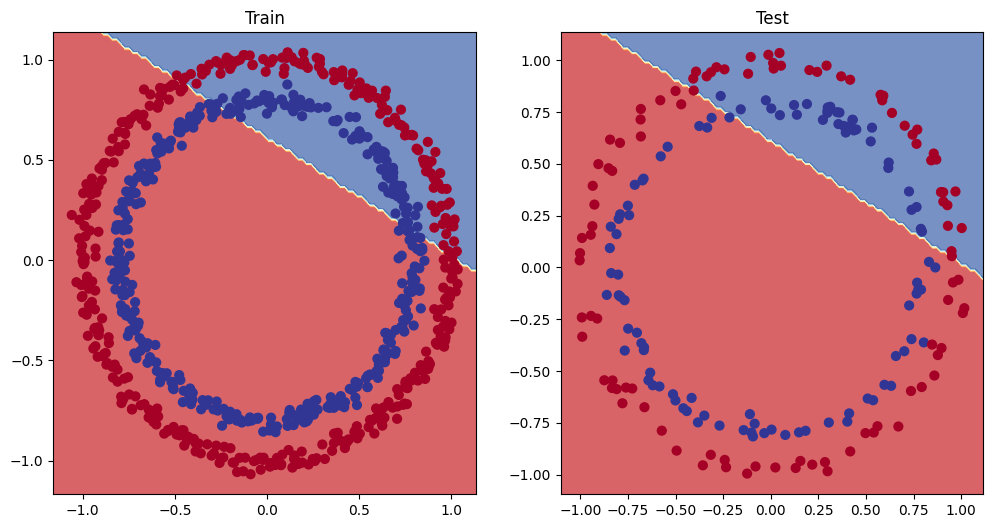

In [58]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Alright, no wonder the loss is not decreasing. The model is learning a straight line separation between the two points. Why is that?

Probably because we are only learning thorugh linear layers